引入必要库

In [1]:
import control as ct  # 控制系统库
import numpy as np    # 数值计算库
import matplotlib.pyplot as plt  # 绘图库
import sympy as sp
from scipy.signal import StateSpace, TransferFunction

一、单位脉冲输入下的标准二阶系统响应

输入阻尼比： 0.707
输入自然频率： 3


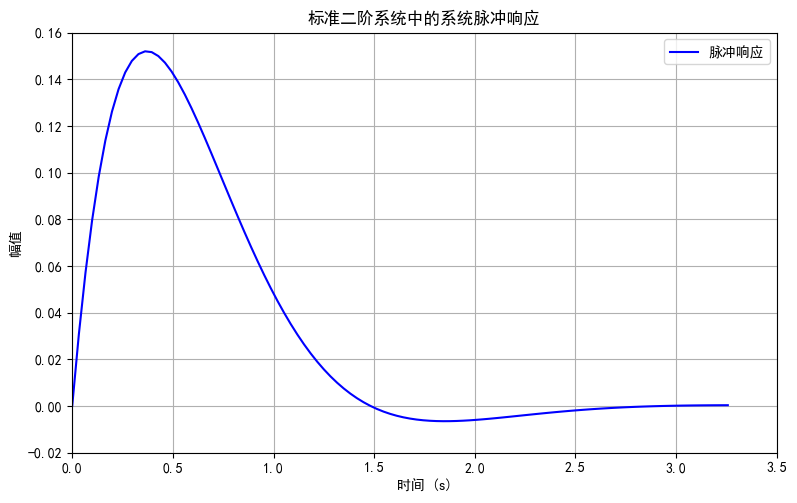

In [48]:
zeta = eval(input('输入阻尼比：')) # 阻尼比
omega_n = eval(input('输入自然频率：')) # 自然频率 (rad/s)
sys = ct.tf([1], [1, 2*zeta*omega_n, omega_n**2]) #传递函数
t, y = ct.impulse_response(sys)

#可视化
plt.figure(figsize = (20, 12))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
plt.subplot(2, 2, 1)
plt.plot(t, y, 'b', label='脉冲响应')
plt.xlabel('时间 (s)')
plt.ylabel('幅值')
plt.title('标准二阶系统中的系统脉冲响应')
plt.legend(['脉冲响应'])
plt.grid(True)
plt.show()

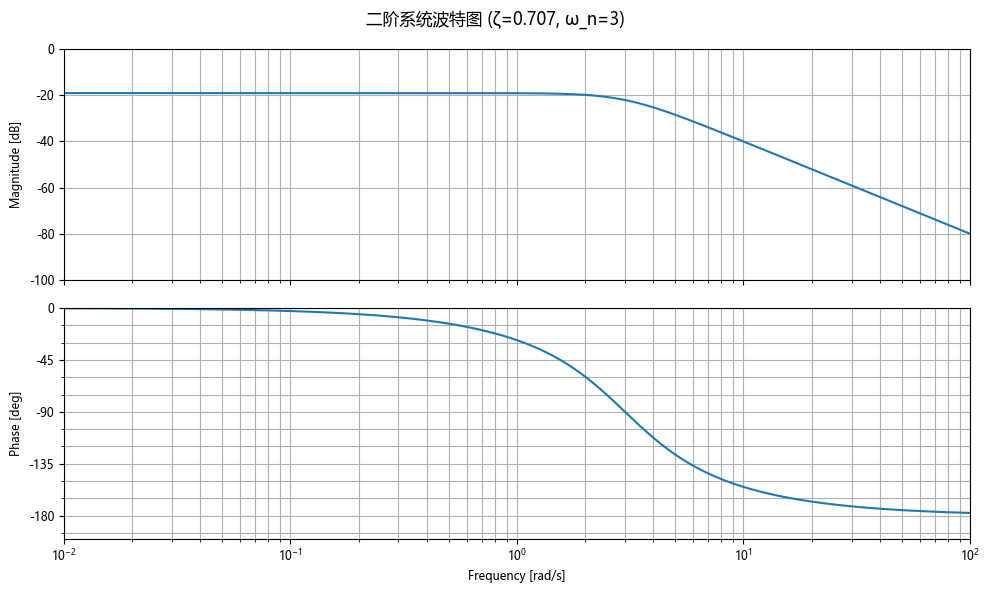


系统特性:
阻尼比 ζ = 0.707
自然频率 ω_n = 3 rad/s
峰值时间 T_p = 1.481 s
超调量 M_p = 4.33%
调节时间 T_s = 1.886 s


In [60]:
# 绘制波特图
# 设置支持 Unicode 的字体
# 创建或修改 Matplotlib 配置文件
mpl.rcParams['font.family'] = 'Microsoft YaHei'
mpl.rcParams['mathtext.fontset'] = 'dejavusans'  # 数学文本也使用相同字体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
plt.figure(figsize=(10, 6))
ct.bode_plot(sys, dB=True, deg=True, omega=np.logspace(-2, 2, 1000))
plt.suptitle(f'二阶系统波特图 (ζ={zeta}, ω_n={omega_n})')
plt.show()

# 计算系统特性
print("\n系统特性:")
print(f"阻尼比 ζ = {zeta}")
print(f"自然频率 ω_n = {omega_n} rad/s")

# 计算并显示时域指标
if zeta < 1:  # 欠阻尼系统
    # 峰值时间
    T_p = np.pi / (omega_n * np.sqrt(1 - zeta**2))
    # 超调量
    M_p = np.exp(-zeta * np.pi / np.sqrt(1 - zeta**2)) * 100
    # 调节时间 (2%准则)
    T_s = 4 / (zeta * omega_n)
    
    print(f"峰值时间 T_p = {T_p:.3f} s")
    print(f"超调量 M_p = {M_p:.2f}%")
    print(f"调节时间 T_s = {T_s:.3f} s")

二、状态空间表示：实现 A矩阵为[[0,1],[-ω_n^2, -2ξω_n]] 的状态矩阵

A、B、C、D矩阵生成函数

In [41]:
def create_second_order_system(omega_n, zeta):
    """
    生成标准二阶系统的状态空间模型
    
    参数:
    omega_n (float): 无阻尼自然频率 [rad/s]
    zeta (float): 阻尼比
    
    返回:
    sys: StateSpace 对象
    """
    # 定义状态矩阵 A
    A = np.array([[0, 1],
                  [-omega_n**2, -2*zeta*omega_n]])
    
    # 定义输入矩阵 B (假设输入作用于第二个状态)
    B = np.array([[0],
                  [omega_n**2]])
    
    # 定义输出矩阵 C (我们观测第一个状态，即位置)
    C = np.array([[1, 0]])
    
    # 定义直接传输矩阵 D
    D = np.array([[0]])
    
    # 创建状态空间系统
    sys = ct.StateSpace(A, B, C, D)
    return sys

系统分析与仿真

输入系统自然频率： 3
输入系统阻尼比： 0.707


状态矩阵 A:
 [[ 0.     1.   ]
 [-9.    -4.242]]
输入矩阵 B:
 [[0.]
 [9.]]
特征值（系统极点）: [-2.121+2.12164064j -2.121-2.12164064j]


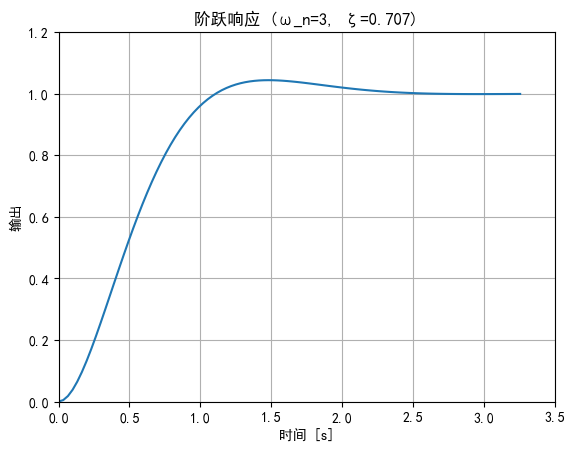

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


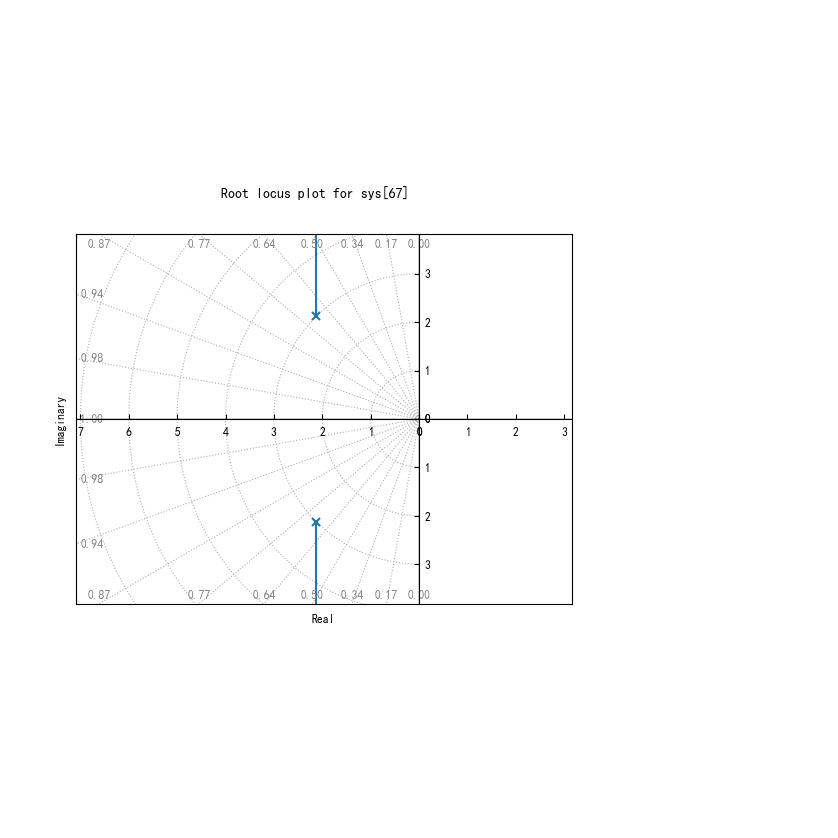

In [46]:
#使用函数创建系统
omega_n = eval(input('输入系统自然频率：')) #自然频率
zeta = eval(input('输入系统阻尼比：')) #阻尼比

my_system = create_second_order_system(omega_n, zeta)

# 1. 打印系统信息
print("状态矩阵 A:\n", my_system.A)
print("输入矩阵 B:\n", my_system.B)
print("特征值（系统极点）:", np.linalg.eig(my_system.A)[0])

# 2. 计算并绘制阶跃响应
t, y = ct.step_response(my_system)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
plt.plot(t, y)
plt.title(f'阶跃响应 (ω_n={omega_n}, ζ={zeta})')
plt.xlabel('时间 [s]')
plt.ylabel('输出')
plt.grid(True)
plt.show()

# 3. 绘制根轨迹（展示极点随增益变化的情况）
ct.root_locus(my_system)
plt.show()

三、模型转换函数

In [2]:
# num_input = eval(input('输入传函分子系数：'))
# den_input = eval(input('输入传函分母系数：'))
num_input = [1, 3, 4]
den_input = [1, 4, 2, 8]

def tf2ss(num, den):
    """
    将传递函数转换为状态空间表示

    参数:
    num -- 分子多项式系数列表，从高次到低次
    den -- 分母多项式系数列表，从高次到低次

    返回:
    A, B, C, D -- 状态空间矩阵
    """
    num = np.array([num], dtype=float)
    den = np.array([den], dtype=float)
    m1 = num.shape[1]
    n1 = den.shape[1]
    A_zero = np.zeros((m1, m1))
    B_zero = np.zeros((m1, 1))
    C_zero = np.zeros((1, m1))
    D_zero = np.array([0])

    if m1 >= n1:
        print('系统不是严格正则系统，不予考虑。')

    else:
        I = np.eye(m1-1, m1-1)
        A_zero[:m1-1, 1:] = I
        A_zero[:m1-1, 0] = 0
        A_zero[m1-1, :] = -1*np.flip(den[0, 1:])
        B_zero[m1-1, :] = 1
        C_zero[0, :] = np.flip(num[0, :])

        A = A_zero
        B = B_zero
        C = C_zero
        D = D_zero

        return A, B, C, D

# A, B, C, D = tf2ss(num_input, den_input)
# print(A, '\n', B, '\n', C, '\n', D)

# a = np.array([[1, 3, 4, 5]], dtype=float)
# print(a.shape)


def ss2tf(A, B, C, D):
    """
    将状态空间表示转换为传递函数

    参数:
    A, B, C, D -- 状态空间矩阵

    返回:
    num, den -- 分子和分母多项式系数列表，从高次到低次
    """
    A = sp.Matrix(A)
    B = sp.Matrix(B)
    C = sp.Matrix(C)
    D = sp.Matrix(D)


    n = A.shape[0]  # 状态数量

    # 使用符号计算
    s = sp.symbols('s')
    I = sp.eye(n)
    # 计算 (sI - A)
    sI_minus_A = s * I - sp.Matrix(A)
    # print('sI_minus_A\n', sI_minus_A)
    # 计算 (sI - A) 的逆
    inv_sI_minus_A = sI_minus_A.inv()
    # 计算传递函数
    tf_op = C * inv_sI_minus_A * B + D
    # print('tf_op\n', tf_op)

    G_s = sp.simplify(C * inv_sI_minus_A * sp.Matrix(B) + D)
    # print('G_s:\n', G_s)

    # 提取分子和分母
    num_poly = sp.Poly(sp.numer(G_s[0]), s)
    den_poly = sp.Poly(sp.denom(G_s[0]), s)

    # # 获取系数
    # num_coeffs = num_poly.all_coeffs()
    # den_coeffs = den_poly.all_coeffs()

    # # 转换为浮点数
    # num_coeffs = [float(coeff) for coeff in num_coeffs]
    # den_coeffs = [float(coeff) for coeff in den_coeffs]

    return num_poly, den_poly

调用

In [3]:
A_op, B_op, C_op, D_op = tf2ss(num_input, den_input)
num_op, den_op = ss2tf(A_op, B_op, C_op, D_op)
print('A矩阵：\n', A_op)
print('B矩阵：\n', B_op)
print('C矩阵：\n', C_op)
print('D矩阵：\n', D_op)
print('传函分子：\n', num_op)
print('传函分母：\n', den_op)

A矩阵：
 [[ 0.  1.  0.]
 [ 0.  0.  1.]
 [-8. -2. -4.]]
B矩阵：
 [[0.]
 [0.]
 [1.]]
C矩阵：
 [[4. 3. 1.]]
D矩阵：
 [0]
传函分子：
 Poly(1.0*s**2 + 3.0*s + 4.0, s, domain='RR')
传函分母：
 Poly(1.0*s**3 + 4.0*s**2 + 2.0*s + 8.0, s, domain='RR')


验证测试

In [4]:
# 测试函数
def test_conversion(num, den):
    """测试转换函数的正确性"""
    # 示例传递函数: (s^2 + 3s + 2) / (s^3 + 4s^2 + 5s + 2)
    num = num
    den = den

    print("原始传递函数:")
    print("分子:", num)
    print("分母:", den)

    # 转换为状态空间
    A, B, C, D = tf2ss(num, den)
    print("\n转换后的状态空间矩阵:")
    print("A:\n", A)
    print("B:\n", B)
    print("C:\n", C)
    print("D:\n", D)

    # 转换回传递函数
    num_back, den_back = ss2tf(A, B, C, D)
    print("\n转换回的传递函数:")
    print("分子:", num_back)
    print("分母:", den_back)

    # 与control实现比较
    sys_tf = ct.tf(num, den)
    sys_ss = ct.ss(sys_tf)

    print("\ncontrol验证:")
    print("原始传递函数:", sys_tf)
    print("转换后的状态空间:", sys_ss)

    # 转换回传递函数
    tf_from_ss = sys_ss.to_tf()
    print("从状态空间转换回的传递函数:", tf_from_ss)

调用测试函数

In [5]:
test_conversion(num_input, den_input)

原始传递函数:
分子: [1, 3, 4]
分母: [1, 4, 2, 8]

转换后的状态空间矩阵:
A:
 [[ 0.  1.  0.]
 [ 0.  0.  1.]
 [-8. -2. -4.]]
B:
 [[0.]
 [0.]
 [1.]]
C:
 [[4. 3. 1.]]
D:
 [0]

转换回的传递函数:
分子: Poly(1.0*s**2 + 3.0*s + 4.0, s, domain='RR')
分母: Poly(1.0*s**3 + 4.0*s**2 + 2.0*s + 8.0, s, domain='RR')

control验证:
原始传递函数: <TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

      s^2 + 3 s + 4
  ---------------------
  s^3 + 4 s^2 + 2 s + 8
转换后的状态空间: <StateSpace>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (3): ['x[0]', 'x[1]', 'x[2]']

A = [[-4. -2. -8.]
     [ 1.  0.  0.]
     [ 0.  1.  0.]]

B = [[1.]
     [0.]
     [0.]]

C = [[1. 3. 4.]]

D = [[0.]]
从状态空间转换回的传递函数: <TransferFunction>: sys[2]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

      s^2 + 3 s + 4
  ---------------------
  s^3 + 4 s^2 + 2 s + 8


四、系统连接：实现 series(), parallel(), feedback() 

定义3种连接函数

In [6]:
def series(sys1, sys2):
    """
    将两个系统串联连接
    
    参数:
        sys1: 第一个系统（StateSpace或TransferFunction）
        sys2: 第二个系统（StateSpace或TransferFunction）
    
    返回:
        串联后的系统
    """
    return sys1 * sys2

def parallel(sys1, sys2):
    """
    将两个系统并联连接
    
    参数:
        sys1: 第一个系统（StateSpace或TransferFunction）
        sys2: 第二个系统（StateSpace或TransferFunction）
    
    返回:
        并联后的系统
    """
    return sys1 + sys2

def feedback(sys1, sys2=None, sign=-1):
    """
    将两个系统连接成反馈形式
    
    参数:
        sys1: 前向通道系统
        sys2: 反馈通道系统（默认为None，表示单位反馈）
        sign: 反馈符号（-1表示负反馈，1表示正反馈）
    
    返回:
        反馈连接后的系统
    """
    return ct.feedback(sys1, sys2, sign)

调用与测试

In [11]:
 # 创建两个示例系统
sys1 = ct.TransferFunction([1], [1, 2, 1])  # 1/(s^2 + 2s + 1)
sys2 = ct.TransferFunction([1, 1], [1, 3])  # (s + 1)/(s + 3)
    
print("系统1:", sys1)
print("系统2:", sys2)
    
# 串联连接
sys_series = series(sys1, sys2)
print("\n串联系统:", sys_series)
    
# 并联连接
sys_parallel = parallel(sys1, sys2)
print("并联系统:", sys_parallel)
    
# 反馈连接（负反馈）
sys_feedback = feedback(sys1, sys2)
print("反馈系统:", sys_feedback)
    
# 状态空间系统的连接示例
A1 = [[-1, 1], [0, -2]]
B1 = [[1], [0]]
C1 = [[1, 0]]
D1 = [[0]]
ss1 = ct.StateSpace(A1, B1, C1, D1)
    
A2 = [[-3]]
B2 = [[1]]
C2 = [[1]]
D2 = [[0]]
ss2 = ct.StateSpace(A2, B2, C2, D2)
    
print("\n状态空间系统1:")
print(ss1)
print("状态空间系统2:")
print(ss2)
    
# 状态空间系统的串联
ss_series = series(ss1, ss2)
print("\n状态空间串联系统:")
print(ss_series)

# 并联连接
ss_parallel = parallel(ss1, ss2)
print("并联系统:", ss_parallel)
    
# 反馈连接（负反馈）
ss_feedback = feedback(ss1, ss2)
print("反馈系统:", ss_feedback)

系统1: <TransferFunction>: sys[21]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

        1
  -------------
  s^2 + 2 s + 1
系统2: <TransferFunction>: sys[22]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  s + 1
  -----
  s + 3

串联系统: <TransferFunction>: sys[23]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

          s + 1
  ---------------------
  s^3 + 5 s^2 + 7 s + 3
并联系统: <TransferFunction>: sys[24]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  s^3 + 3 s^2 + 4 s + 4
  ---------------------
  s^3 + 5 s^2 + 7 s + 3
反馈系统: <TransferFunction>: sys[25]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

          s + 3
  ---------------------
  s^3 + 5 s^2 + 8 s + 4

状态空间系统1:
<StateSpace>: sys[26]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[-1.  1.]
     [ 0. -2.]]

B = [[1.]
     [0.]]

C = [[1. 0.]]

D = [[0.]]
状态空间系统2:
<StateSpace>: sys[27]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (1): ['x[0]']

A = [[-3.]]

B = [[1.]]

C = [[1.]]

D = [[0.]]

状态空间串联系统:
<Stat